In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [11]:
import glob
import pickle
import warnings
import numpy as np
import pylab as plt

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ
from utils.utils import radialMask
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot
from zernikies import zernikeWLS, getZernikeCoeffs
from bad_scans import october_bad_scans as bad_scans
from parabolas import loadLeicaData, fitParabola, parabola
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [3]:
from scipy.optimize import least_squares

def parabolaFit(x, y, z, guess, bounds=None, 
                max_nfev=10000, ftol=1e-12, 
                xtol=1e-12, verbose=False):
    
    # Set boundaries for the fit parameters.
    if bounds is None:
        inf = np.inf
        pi2 = 2*np.pi
        b1 = [0., -inf, -inf, -inf, -pi2, -pi2]
        b2 = [inf, inf,  inf,  inf,  pi2,  pi2]
        bounds = (b1, b2)
    
    # Robust fit: weights outliers outside of f_scale less
    loss = "soft_l1"
    f_scale = 1.0

    method = fitParabola
    args = (x.flatten(), y.flatten(), z.flatten())
    
    r = least_squares(method,
                      guess,
                      args=args,
                      bounds=bounds,
                      max_nfev=max_nfev,
                      loss=loss,
                      f_scale=f_scale,
                      ftol=ftol,
                      xtol=xtol)
    return r

def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        x_ = x[~mask]
        y_ = y[~mask]
        z_ = z[~mask]
        fit = parabolaFit(x_, y_, z_, guess, bounds=bounds)
        cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
        xdr, ydr, zdr = shiftRotateXYZ(x, y, z, cor)
        zp = parabola(xdr, ydr, fit.x[0])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = res.mask
    
    return fit, mask

def removeParabolaScan(filename, iters, n=512, guess=[60., 0, 0, -50., 0, 0], bounds=None, fit=None):
    """
    """
    
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    xg, yg, zg = regridXYZ(x, y, z, n=n)
    xg, yg, zg = shiftRotateXYZ(xg, yg, zg, [0, 0, 0, 0, 0, np.deg2rad(178)])
    fit_, refMask = parabolaFitIterations(xg, yg, zg, guess=guess, bounds=bounds, iters=iters)
    if fit is None:
        fit = fit_
    cor = np.hstack((-1*fit.x[1:4],fit.x[4:],0))
    xgdr, ygdr, zgdr = shiftRotateXYZ(xg, yg, zg, cor)
    zgdr[refMask] = np.nan
    tht = np.arctan2(np.nanmax(zgdr)-np.nanmin(zgdr), np.nanmax(ygdr)-np.nanmin(ygdr))
    xgr, ygr, zgr = shiftRotateXYZ(xgdr, ygdr, zgdr, [0, 0, 0, -tht, 0, 0])
    zp = parabola(xgdr, ygdr, fit.x[0])
    _, _, zpr = shiftRotateXYZ(xgdr, ygdr, zp, [0, 0, 0, -tht, 0, 0])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        diff = sigma_clip(zgr - zpr)
        
    return xgr, ygr, diff, fit

In [4]:
n = 512
iters = 2
nZern = 36
guess = [60., 0., 0., -50., 0., 0.]
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [7]:
# Load the pickle containing the information about the October 9 scans.
fn = '../../data/October2019/lassiScans9oct2019_v3.pickle'
scanDict = pickle.load( open(fn, "rb"), encoding='bytes')
scans = list(scanDict.keys())

In [9]:
%%time
refScan = "{0}/ref_average.ptx.csv".format(scanDir)
xr, yr, rDiff, rFit = removeParabolaScan(refScan, iters, n=512, guess=[60., 0, 0, -50., 0, 0], bounds=None)

CPU times: user 2min 30s, sys: 2min 10s, total: 4min 41s
Wall time: 18.5 s


In [159]:
%%time

zFitDict = {}

betaDict = {5:1.1, 6:1.1, 7:1.15, 8:1.1, 9:1.1, 10:1.1, 11:1.1, 12:1.1, 13:1.3, 14:1.1, 
            15:1.3, 16:1.1, 17:1.1, 18:1.1, 19:1.1, 20:1.1, 21:1.1, 22:1.1, 23:1.1, 24:1.1, 25:1.1,
            26:1.1, 27:1.1, 28:1.1, 29:1.1, 30:1.1, 31:1.1, 32:1.1, 33:1.1, 34:1.1, 35:1.1, 36:1.1,
            37:1.1,
           }

stds = np.arange(0, 20, 2)
#exp_fac = lambda rms: np.exp(-np.power((stds[4] - stds)/(5.*rms*1e6/60.), 2.))
scale_bias = lambda beta: np.power(beta, -1.+1.*np.log2(stds/1.))

from astropy.convolution import Gaussian2DKernel, convolve

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for k in scans:
        if scanDict[k][b'configuration'][b'az_fov'] == 360. and scanDict[k][b'type'] == b'SIGNAL' \
        and k not in bad_scans and (k <= 475 and k >= 435):
        
            try:
                sigScanFile = "{0}/{1}.csv".format(scanDir, scanDict[k][b'ptx'].decode('ascii'))
            except KeyError:
                continue

            xs, ys, sDiff, sFit = removeParabolaScan(sigScanFile, iters, n=n, guess=guess)#, fit=rFit)

            diff = sigma_clip(sDiff - rDiff, 5)
            xDiff = xr
            yDiff = yr

            fl = np.zeros(nZern+1, dtype=np.float)

            fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')

            flArr = np.zeros((len(stds), nZern+1), dtype=np.float)

            for j,std in enumerate(stds):
                if std != 0:
                    kernel = Gaussian2DKernel(x_stddev=std)
                    diffSmo = convolve(diff, kernel, preserve_nan=True)
                else:
                    diffSmo = np.ma.copy(diff)
                diff_ = np.ma.copy(diffSmo)
                diff_[~radialMask(xDiff, yDiff, 49.5)] = np.nan
                diff_ = np.ma.masked_invalid(diff_)

                flArr[j] = zernikeWLS(xDiff[:,::-1], yDiff[::-1,:], diff_[::-1,::-1], nZern, weighted=False)

            for j in range(4,nZern+1):
                if j == 4:
                    fl[j] = fl_fs[j]
                else:
                    if fl_fs[j] < flArr[0,j] and j in [13]:
                        fl[j] = fl_fs[j]
                    else:
                        sb = scale_bias(betaDict[j])
                        best_idx = np.argmax(abs(flArr[1:,j])*1e6*sb[1:])
                        fl[j] = flArr[best_idx+1,j]

            zFitDict[k] = {'recovered zernike': fl,
                           'deformation map z': diff,
                           'deformation map x': xDiff,
                           'deformation map y': yDiff,
                             }

CPU times: user 1h 5min 10s, sys: 44min 28s, total: 1h 49min 38s
Wall time: 20min 24s


In [168]:
%%time
zindxs = [7, 13, 15]
zcoefs = np.arange(0., 500., 10.)*1e-6 # m
eps_tot, eta_tot = make_aperture_efficiency(zindxs, zcoefs, n=256, eps=225e-6)

CPU times: user 44.7 s, sys: 8.19 ms, total: 44.7 s
Wall time: 44.7 s


In [169]:
%%time

w = np.zeros(len(zFitDict.keys()), dtype=np.float)
zin = np.zeros(len(zFitDict.keys()), dtype=np.float)
mjds = np.zeros(len(zFitDict.keys()), dtype=np.float)
zobs = np.zeros((len(zFitDict.keys())), dtype=np.float)
zinval = np.zeros(len(zFitDict.keys()), dtype=np.float)
residuals = np.zeros((len(zFitDict.keys())), dtype=np.float)

for i,k in enumerate(list(zFitDict.keys())):
    
    w[i] = scanDict[k][b'wind(m/s)']
    zi = scanDict[k][b'zernike index']
    ci_obs = zFitDict[k]['recovered zernike'][zi]
    
    if scanDict[k][b'zernike value'] == 1000.:
        ci = -1080.
        if zi == 15:
            ci = -1*ci
    elif scanDict[k][b'zernike value'] == 500.:
        ci = -594.
        if zi == 15:
            ci = -1*ci
    elif scanDict[k][b'zernike value'] == 150.:
        ci = -225.
        if zi == 15:
            ci = -1*ci
    else:
        ci = scanDict[k][b'zernike value']
    
    zin[i] = zi
    zinval[i] = ci
    zobs[i] = ci_obs
    residuals[i] = abs(ci - ci_obs)
    mjds[i] = (scanDict[k]['t0'].mjd + scanDict[k]['tf'].mjd)/2.

CPU times: user 648 µs, sys: 432 µs, total: 1.08 ms
Wall time: 1.06 ms


In [170]:
%%time
time = Time(mjds, format='mjd')
eta_as = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, np.asarray(zindxs), np.zeros(len(zindxs)), np.ones(len(zindxs))*25.)
eta_res = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs*1e6)
#eta_res_wls = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,1]*1e6)
#eta_res_comb = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs.mean(axis=1)*1e6)

CPU times: user 2.1 ms, sys: 0 ns, total: 2.1 ms
Wall time: 1.73 ms


In [171]:
eta_as

array([0.21873553, 0.21837705, 0.21884923])

<IPython.core.display.Javascript object>


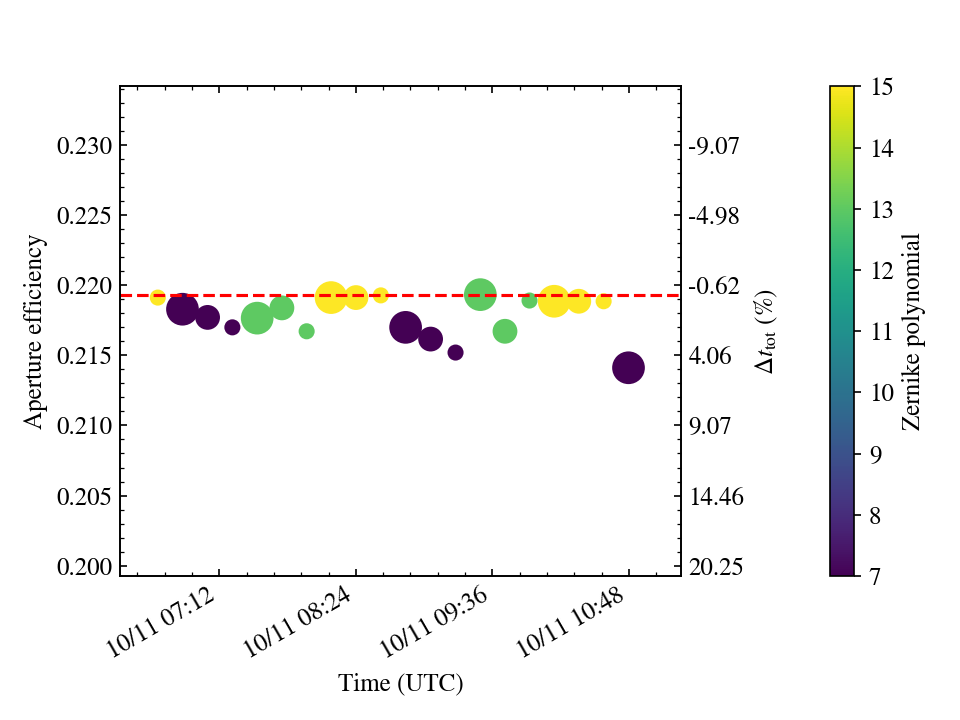

In [177]:
from matplotlib.dates import DateFormatter
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('font', **{'family':'STIXGeneral', 'weight':'normal'})
matplotlib.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 12})

formatter = DateFormatter('%m/%d %H:%M')

fig = plt.figure(dpi=150, frameon=False)

ax = fig.add_subplot(111)
axr = ax.twinx()

ax.axhline(y=np.max(eta_tot), color='r', linestyle='--')
#for eas in eta_as:
#    ax.axhline(y=eas, color='k', linestyle='--')

sc = ax.scatter(time.plot_date, eta_res, c=zin, s=abs(zinval)/5., marker='o')
#sc = ax.scatter(time.plot_date, eta_res_wls, c=zin, s=abs(zinval)/5., marker='d', alpha=0.5)
#sc = ax.scatter(time.plot_date, eta_res_comb, c=zin, s=abs(zinval)/5., marker='o')
cb = plt.colorbar(sc, fraction=0.046, pad=0.2)
cb.set_label('Zernike polynomial')
ax.minorticks_on()
ax.tick_params('both', direction='in', which='both', top=True, right=False, left=True, bottom=True)
#ax.set_xlabel("Scan")
ax.set_ylabel("Aperture efficiency")

ax.xaxis.set_major_formatter(formatter)
ax.set_xlabel('Time (UTC)')

l = ax.get_ylim()
l2 = axr.get_ylim()
f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
ticks = f(ax.get_yticks())
axr.yaxis.set_major_locator(plt.matplotlib.ticker.FixedLocator(ticks))

labels = ["{:.2f}".format((np.power(eta_/np.nanmax(eta_tot), -2.) - 1)*100.) for eta_ in ax.get_yticks()]
axr.set_yticklabels(labels)
axr.set_ylabel("$\Delta t_{\mathrm{tot}}$ (%)")
axr.minorticks_on()
axr.tick_params('both', direction='in', which='both', top=False, right=True, left=False, bottom=False)
axr.yaxis.set_minor_locator(plt.matplotlib.ticker.AutoMinorLocator(5))

fig.autofmt_xdate()

plt.savefig("eta_scan_October2019_quiet.pdf", bbox_inches='tight', pad_inches=0.06)

In [155]:
idx = 6
print(zin[idx], zinval[idx], zobs[idx].mean()*1e6, zinval[idx] - zobs[idx].mean()*1e6)

13.0 -225.0 -175.9209727165846 -49.0790272834154


In [178]:
print(np.max(eta_tot), np.mean(eta_res), np.power(np.mean(eta_res)/np.max(eta_tot), -2.), np.power(np.min(eta_res)/np.max(eta_tot), -2.))
#erc = np.hstack((eta_res[:4],eta_res[5:13],eta_res[14:]))
erc = np.hstack((eta_res[:6],eta_res[7:]))
print(np.max(eta_tot), np.mean(erc), np.power(np.mean(erc)/np.max(eta_tot), -2.))

0.21932075789662847 0.21781135270474827 1.0139077708010797 1.0492700762724567
0.21932075789662847 0.21786935254379058 1.0133680100750027


In [149]:
print(np.max(eta_tot), np.mean(eta_res), np.power(np.mean(eta_res)/np.max(eta_tot), -2.))
erc = np.hstack((eta_res[:6],eta_res[7:]))
print(np.max(eta_tot), np.mean(erc), np.power(np.mean(erc)/np.max(eta_tot), -2.))

0.20804304085861067 0.2040313356536482 1.03971100487823
0.20804304085861067 0.2040313356536482 1.03971100487823


In [137]:
sigScans = np.array(list(zFitDict.keys()))
mask = (sigScans <= 475) & (sigScans >= 435)
scanDict[sigScans[mask][6]]
#scanDict[406]

{b'elevation': 50.0,
 b'ptx (bytes)': b' 712282170',
 b'ptx': b'448_2019-10-11_04:00:54.ptx',
 b'dt': datetime.datetime(2019, 10, 11, 3, 57, 4),
 b'configuration': {b'project': b' 9oct2019',
  b'cntr_az': 270.0,
  b'az_fov': 360.0,
  b'cntr_el': 45.0,
  b'el_fov': 90.0,
  b'sensitivity': b' Normal',
  b'resolution': b' 63mm@100m',
  b'scan_mode': b' Speed'},
 b'AS in SC?': 0,
 b'scan #': 448,
 b'export (mins)': 4.23,
 b'AS Scan #': 568,
 b'scan (mins)': 1.55,
 b'AS FITS': {b'DATE-OBS': b'2019-10-11T07:56:56',
  b'ZERNIKES': [(b'Z13', 150.0)],
  b'proj': b'TINT',
  b'filename': b'2019_10_11_07:56:56.fits',
  b'SCAN': 568},
 b'zernike value': 150.0,
 b'wind(m/s)': 0.2,
 b'zernike index': 13,
 b'type': b'SIGNAL',
 't0': <Time object: scale='utc' format='mjd' value=58767.3314535471>,
 'tf': <Time object: scale='utc' format='mjd' value=58767.332529935986>,
 'input zernike active surface fit': 13,
 'input zernike value active surface fit': 591.9610019994549}